# État de l'emploi bioinformatique en France : partie 2

Nous revoila pour la suite de notre [premier article](http://bioinfo-fr.net/etat-de-lemploi-bioinformatique-en-france-analyse-des-offres-de-la-sfbi) sur l'analyse des offres de la SFBI des 4 dernières années.
On vous avait promis une analyse de l'évolution du marché, et c'est ce dont nous allons parler dans cet article.

Je vous renvoie au premier article si vous voulez plus d'informations sur l'origine des données et la disponibilité du code.
Les contributions sur le [Github du projet](https://github.com/royludo/SFBIStats) ont été bien ternes... ou plutôt inexistantes.
C'est bien dommage car nous nourrissions le secret espoir de publier ici vos meilleurs graphes.
Du coup, on a dû tout faire nous même, entre de la rédaction de chapîtres de thèses ou l'analyse de données microfluidiques.

Le code n'est probablement pas facile à prendre en main.
Nous avons ainsi choisi un format _jupyter notebook_ pour ce second article.
Texte, code et graphes sont mélés dans ce qui suit, en espérant que ça suscite des vocations pour améliorer nos graphes, et surtout, en créer d'autres.
L'article est, de fait, un poil plus technique que le précédent.
Notons qu'il s'agit d'un excellent exemple de l'utilisation du module python [pandas](http://pandas.pydata.org/) sur des données réelles.

## Chargement des modules nécessaires et des données

On entre donc dans le vif du sujet en commençant par charger les données de la base de données MongoDB que [lroy](http://bioinfo-fr.net/crew) a gentillement mise à jour sur le github depuis le premier article.

In [1]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 100 # bigger figures in notebook mode
matplotlib.rcParams['savefig.dpi'] = 100 # bigger figures in inline mode
colors = ['#6f3883', '#87ad3e', '#fce33e', '#4066c7', '#cc3428'] # colorpalette from bioinfo-fr
from __future__ import unicode_literals, print_function
import json, os
from bson import json_util
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mpldates
import numpy as np

from sfbistats import utils

In [2]:
with open('../../resources/jobs_anon.json', 'r') as input_file: # emplacement de la BDD
    job_list = utils.load_from_json(input_file) # création de la liste de jobs
print('Nombre total d\'offres', len(job_list))
print('Champs :', job_list[0].keys())

Nombre total d'offres 1437
Champs : ['submission_date', 'contract_subtype', 'validity_date', 'duration', 'contract_type', 'city', 'title', 'limit_date', u'department', 'starting_date', u'region']


On constate que l'on a gagné environ 150 offres depuis [la dernière fois](http://bioinfo-fr.net/etat-de-lemploi-bioinformatique-en-france-analyse-des-offres-de-la-sfbi).
Vous pouvez voir que chaque offre dans *job\_list* est un dictionnaire qui contient 11 clés.
Comme ce n'est pas très pratique à manipuler, on va créer ce que l'on appelle un *dataframe* grâce au module Pandas.
Au passage on ne va récupérer que les champs potentiellement intéressants pour cet article.

In [3]:
df = pd.DataFrame(job_list, columns=['contract_type',
                                     'contract_subtype',
                                     'duration',
                                     'submission_date'])
df.submission_date = pd.to_datetime(df.submission_date)
df.describe() # On affiche un résumé du dataframe.

,contract_type,contract_subtype,duration,submission_date
count,1437,1437,1437,1437
unique,4,11,33,671
top,CDD,,6,2015-11-09 00:00:00
freq,785,412,253,12
first,NaN,NaN,NaN,2012-04-23 00:00:00
last,NaN,NaN,NaN,2016-05-19 00:00:00


## Evolution du nombre d'offres sur la période 2012-2016

Premier exemple avec un petit graphe tout simple : peut-on tracer l'évolution de la quantité d'offres au cours du temps ? On peut obtenir ça très facilement en quelques lignes avec la puissance du module Pandas.

In [4]:
# On prend la colonne submission_date du dataframe et on rééchantillonne par bimestre
date_serie = df.submission_date.value_counts().resample('2M', how='sum')
date_serie

2012-04-30      3
2012-06-30      9
2012-08-31     10
2012-10-31     20
2012-12-31     20
2013-02-28     29
2013-04-30     29
2013-06-30     25
2013-08-31     33
2013-10-31     44
2013-12-31     63
2014-02-28     75
2014-04-30     33
2014-06-30     47
2014-08-31     61
2014-10-31     86
2014-12-31     83
2015-02-28     93
2015-04-30     78
2015-06-30     68
2015-08-31     55
2015-10-31    101
2015-12-31    130
2016-02-29    110
2016-04-30     96
2016-06-30     36
Freq: 2M, Name: submission_date, dtype: int64

Comme vous pouvez le voir, on obtient en une seule ligne de code l'information demandée, il ne reste plus qu'à optimiser l'affichage.

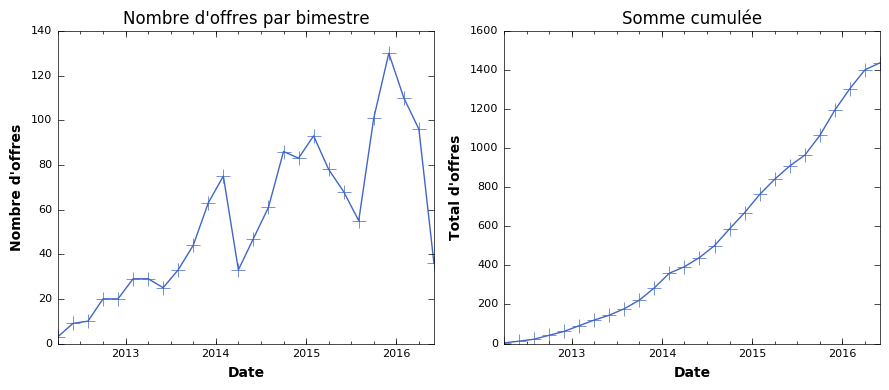

In [5]:
kwargsplot = {'marker': '+', 'markersize': 10, 'color': colors[3], 'lw': 1, 'ls': '-'}
fig, axx = plt.subplots(1,2, figsize=(9,4))
date_serie.plot(ax=axx[0], **kwargsplot) # j'affiche la somme par bimesre
date_serie.cumsum().plot(ax=axx[1], **kwargsplot) # j'affiche la somme cumulée

axx[0].set_title(u'Nombre d\'offres par bimestre')
axx[0].set_ylabel("Nombre d'offres")
axx[1].set_title(u'Somme cumulée')
axx[1].set_ylabel("Total d'offres")
for ax in axx.flatten():
    ax.set_xlabel('Date')
fig.tight_layout()

Puissant n'est-ce pas ?
Évidemment on y arrive rarement du premier coup au début, mais avec la pratique et à force d'exemples, on finit par comprendre la logique du module.

On peut aussi utiliser le sous-module dates de matplotlib pour obtenir un graphe légèrement plus élaboré (avec par exemple, une meilleure lisibilité des mois de l'année).
Cela prend quelques lignes de plus car nous n'exploitons plus les méthodes de tracé intégrées à Pandas.

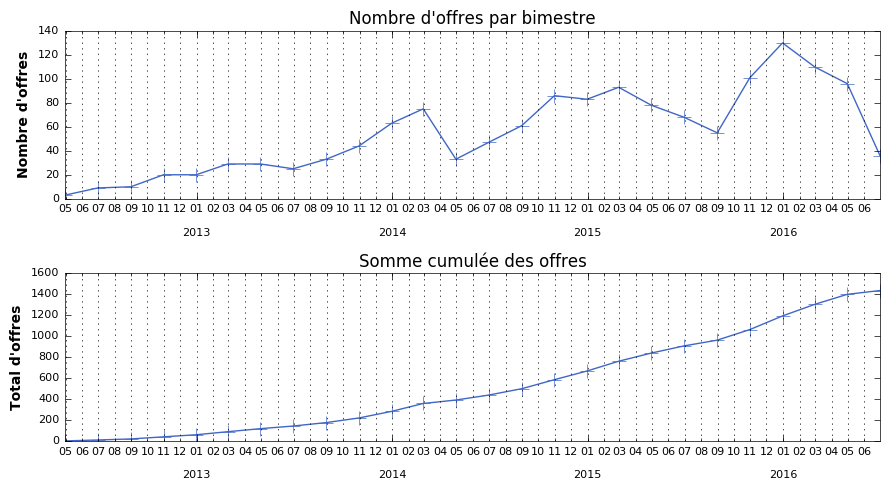

In [6]:
dd, mm = date_serie.index.to_pydatetime(), date_serie
cummm = date_serie.cumsum()

kwargsplot = {'marker': '+', 'markersize': 10, 'color': colors[3], 'lw': 1, 'ls': '-'}
fig, axx = plt.subplots(2,1, figsize=(9,5))
axx[0].plot_date(dd, mm, **kwargsplot) # j'affiche la somme par mois
axx[1].plot_date(dd, cummm, **kwargsplot) # j'affiche la somme cumulée

axx[0].set_title(u'Nombre d\'offres par bimestre')
axx[0].set_ylabel("Nombre d'offres")
axx[1].set_title(u'Somme cumulée des offres')
axx[1].set_ylabel("Total d'offres")
for ax in axx.flatten():
    ax.xaxis.set_minor_locator(mpldates.MonthLocator(bymonth=(1),interval=1))
    ax.xaxis.set_minor_formatter(mpldates.DateFormatter('%m'))
    ax.xaxis.grid(True, which="minor")
    ax.xaxis.set_major_locator(mpldates.YearLocator())
    ax.xaxis.set_minor_locator(mpldates.MonthLocator())
    ax.xaxis.set_major_formatter(mpldates.DateFormatter('\n\n%Y'))
fig.tight_layout()

On voit que la fréquence de publication des offres augmente pas mal au cours du temps.
Notons que la SFBI pousse de plus en plus à passer par son site internet, ce qui pourrait facilement expliquer cette tendance (notre jeu de données ne prend que les offres hébergées par le site).
On devine aussi quelques variations saisonnières, avec notamment un creux chaque année autour de la période estivale.
Le record d'offres apparaît pour le mois de novembre 2015, avec une moyenne supérieure à 2,5 offres par jour.
On voit également que depuis plusieurs mois la liste s'est maintenue au dessus de 1 offre par jour (la chute finale est simplement due au fait que le bimestre n'est pas fini).

## Évolution des types d'offres sur la période 2012-2016

De quels types d'offres parle-t-on ?
Est-ce que comme l'a évoqué [Sophie Schbath](http://bioinfo-fr.net/questions-a-sophie-schbath), la proportion de contrats courts augmente, ou s'agit-il d'un biais de perception ?
Un premier point intéressant serait de tracer le graphe précédent par type de contrat, ce qui se fait là encore très facilement dans Pandas.

In [7]:
df_per_type = df[['submission_date', 'contract_type']] # On crée une sous dataframe
df_per_type = df_per_type.set_index('submission_date') # On met les dates en index
gb = df_per_type.groupby(pd.TimeGrouper('2M')) # On groupe par période de 2 mois
# Enfin, on compte chaque occurence de contrat dans les périodes définies
df_count_per_type = gb.contract_type.apply(lambda x: x.value_counts()).unstack().fillna(0) 
df_count_per_type

,CDD,CDI,Stage,Thèse
submission_date,,,,
2012-04-30,1,0,1,1
2012-06-30,6,0,0,3
2012-08-31,9,1,0,0
2012-10-31,15,3,2,0
2012-12-31,11,2,7,0
2013-02-28,17,1,10,1
2013-04-30,20,5,2,2
2013-06-30,19,4,2,0
2013-08-31,26,4,2,1


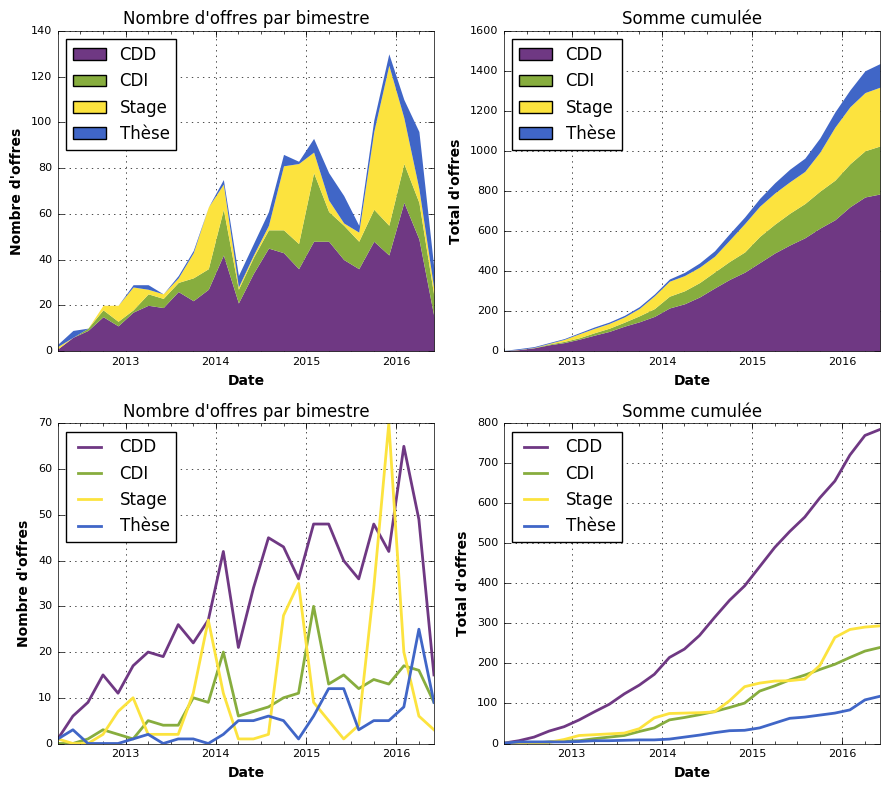

In [8]:
fig, axx = plt.subplots(2,2, figsize=(9,8))
df_count_per_type.plot(ax=axx[0,0], kind='area', color=colors, lw=0)
df_count_per_type.cumsum().plot(ax=axx[0,1], kind='area', color=colors, lw=0)
df_count_per_type.plot(ax=axx[1,0], kind='line', color=colors, lw=2)
df_count_per_type.cumsum().plot(ax=axx[1,1], kind='line', color=colors, lw=2)
for ax in axx[:,0]:
    ax.set_title(u'Nombre d\'offres par bimestre')
    ax.set_ylabel("Nombre d'offres")
for ax in axx[:,1]:
    ax.set_title(u'Somme cumulée')
    ax.set_ylabel("Total d'offres")
for ax in axx.flatten():
    ax.set_xlabel('Date')
    ax.grid()
    ax.set_axisbelow(True) 
fig.tight_layout()

Il semblerait effectivement que la quantité de CDD augmente plus vite que les autres types offres.
On observe aussi que l'abondonance d'offres de stage est très saisonnière : très peu d'offres toute l'année, et un énorme pic d'octobre à décembre, le point culminant se situant toujours en novembre.
Il vaut donc mieux chercher son stage dans cette période là et ne pas attendre l'année suivante.

Les CDI et les thèses sont plutôt constants.
On observe évidemment pour les thèses un petit pic au début de chaque année, probablement dû au fait que les concours d'écoles doctorales se tiennent de mai à juillet.
Les CDI montrent un pic pendant les mois de février 2014 et 2015 pour une raison qui nous échappe, mais ce phénomène ne semble pas s'être produit en 2016 (avec à la place, un pic de CDD ?).
Est-ce que les incertitudes autour du projet de loi travail y seraient pour quelque chose ?

## Évolution des types de CDD sur la période 2012-2016

On rappelle que l'on a 4 sous-catégories de CDD dans la base, telles que définies sur le site de la SFBI au moment d'entrer une offre : Post-doc / IR, CDD Ingénieur, ATER, et CDD autre.
Le jeu de données ne comprend que 2 offres ATER sur toute la période, on va donc exclure cette catégorie de l'analyse.
Pour rappel, les Post-docs occupaient à eux seuls 50\% du nombre de CDD publiés dans notre dernier article.
Cette proportion a-t-elle changée au cours du temps ?

In [9]:
df_CDD = df[(df['contract_type'] == 'CDD') & (df['contract_subtype'] != 'ATER')] # On filtre pour ne garder que les CDDs, sans les ATER
df_per_CDD_subtype = df_CDD[['submission_date', 'contract_subtype']] # On crée une sous dataframe
df_per_CDD_subtype = df_per_CDD_subtype.set_index('submission_date') # On met les dates en index
gb = df_per_CDD_subtype.groupby(pd.TimeGrouper('2M')) # On groupe par période de 2 mois
df_count_per_subtype = gb.contract_subtype.apply(lambda x: x.value_counts()).unstack().fillna(0) # On compte chaque occurence de contrat
df_count_per_subtype

,CDD Ingénieur,CDD autre,Post-doc / IR
submission_date,,,
2012-04-30,0,0,1
2012-06-30,2,0,4
2012-08-31,3,0,6
2012-10-31,10,2,3
2012-12-31,2,3,6
2013-02-28,9,1,7
2013-04-30,14,3,3
2013-06-30,9,3,7
2013-08-31,14,2,10


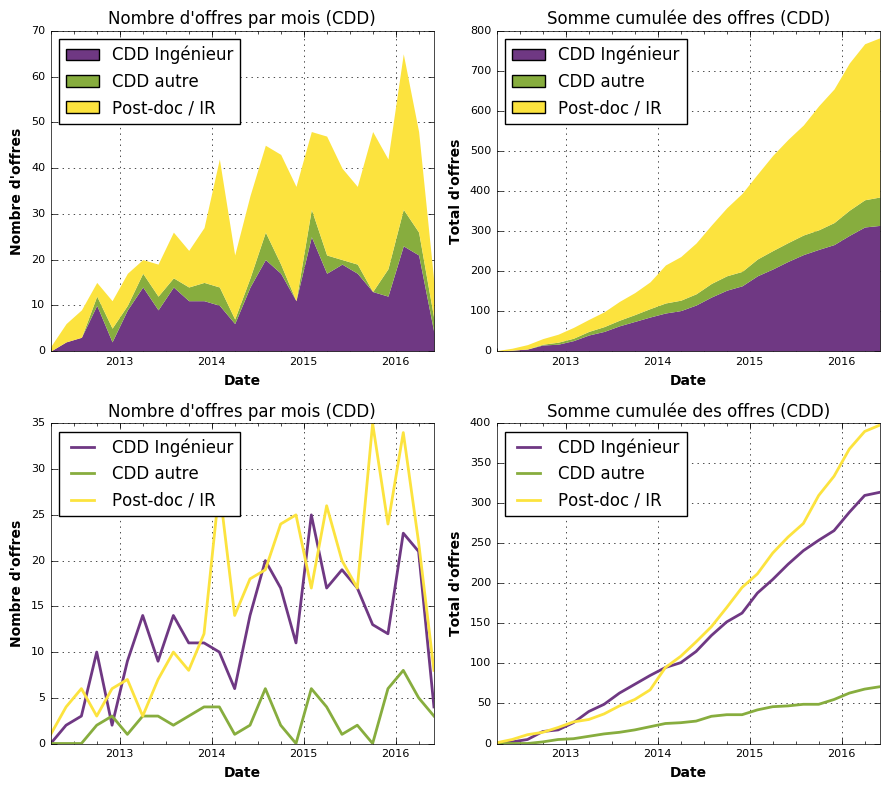

In [10]:
fig, axx = plt.subplots(2,2, figsize=(9,8))
df_count_per_subtype.plot(ax=axx[0,0], kind='area', color=colors, lw=0)
df_count_per_subtype.cumsum().plot(ax=axx[0,1], kind='area', color=colors, lw=0)
df_count_per_subtype.plot(ax=axx[1,0], kind='line', color=colors, lw=2)
df_count_per_subtype.cumsum().plot(ax=axx[1,1], kind='line', color=colors, lw=2)
for ax in axx[:,0]:
    ax.set_title(u'Nombre d\'offres par mois (CDD)')
    ax.set_ylabel("Nombre d'offres")
for ax in axx[:,1]:
    ax.set_title(u'Somme cumulée des offres (CDD)')
    ax.set_ylabel("Total d'offres")
for ax in axx.flatten():
    ax.set_xlabel('Date')
    ax.grid()
    ax.set_axisbelow(True) 
fig.tight_layout()

Il semblerait que le parent pauvre des sous-types de CDD soit le CDD autre.
On a ainsi massivement des CDD ingénieur ou Post-doc/IR, dans des proportions et augmentations comparables.
Une séparation entre privé et public serait intéressante, mais nous n'avons pas les données nécessaires pour le faire à l'heure actuelle.

## Évolution de la durée des CDD sur la période 2012-2016

Une donnée a laquelle nous avons cependant accès est la durée de ces CDD.
Les contrats signés ont-ils tendance à l'être pour des durées plus courtes ou plus longues ?
Comme nous l'avons vu dans l'article précédent, la nature discrète des durées de contrats rend les distributions de durées assymétriques.
Il peut donc être intéressant de visualiser ça sous forme de catégories.

In [11]:
# On définit nos catégories
list_categories = [u'≤ 1 an',
                   u'1 < x ≤ 2 ans',
                   u'> 2 ans']
# On crée une fonction qui retourne la catégorie à partir de la durée en mois
def get_category(months):
    cat_num = months//12
    div_remain = months%12
    if div_remain == 0: cat_num -= 1# pour avoir ≤ et non pas <
    if cat_num < 2:
        return list_categories[cat_num]
    else:
        return list_categories[-1]

is_CDD = df.contract_type == 'CDD'
is_sanitized = (0 < df.duration) & (df.duration < 100)
df_duration = df[is_CDD & is_sanitized][['duration', 'submission_date']]
df_duration['category'] = df_duration.loc[:,'duration'].apply(get_category)
df_duration = df_duration.set_index('submission_date')
gb = df_duration.groupby(pd.TimeGrouper('2M')) # On groupe par période de 2 mois
df_count_per_duration = gb.category.apply(lambda x: x.value_counts()).unstack().fillna(0) # On compte chaque occurence de contrat
df_count_per_duration = df_count_per_duration.reindex(columns=list_categories)
df_count_per_duration

,≤ 1 an,1 < x ≤ 2 ans,> 2 ans
submission_date,,,
2012-04-30,0,1,0
2012-06-30,2,3,0
2012-08-31,2,5,2
2012-10-31,7,6,0
2012-12-31,3,4,3
2013-02-28,8,7,2
2013-04-30,7,11,2
2013-06-30,10,3,4
2013-08-31,7,12,6


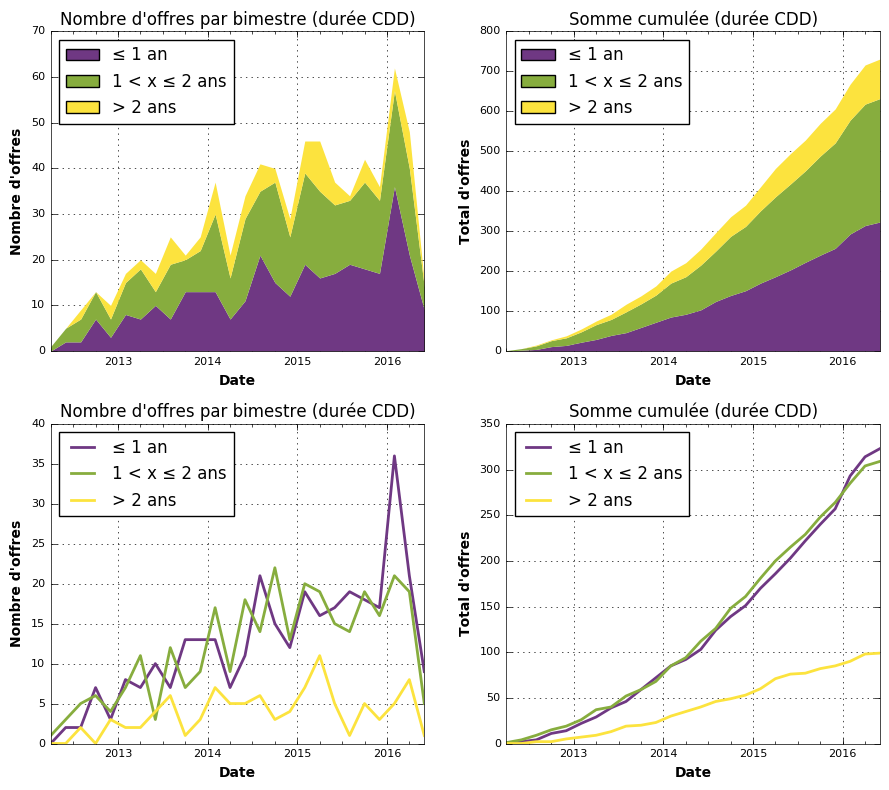

In [12]:
fig, axx = plt.subplots(2,2, figsize=(9,8))
df_count_per_duration.plot(ax=axx[0,0], kind='area', color=colors, lw=0)
df_count_per_duration.cumsum().plot(ax=axx[0,1], kind='area', color=colors, lw=0)
df_count_per_duration.plot(ax=axx[1,0], kind='line', color=colors, lw=2)
df_count_per_duration.cumsum().plot(ax=axx[1,1], kind='line', color=colors, lw=2)
for ax in axx[:,0]:
    ax.set_title(u'Nombre d\'offres par bimestre (durée CDD)')
    ax.set_ylabel("Nombre d'offres")
for ax in axx[:,1]:
    ax.set_title(u'Somme cumulée (durée CDD)')
    ax.set_ylabel("Total d'offres")
for ax in axx.flatten():
    ax.set_xlabel('Date')
    ax.grid()
    ax.set_axisbelow(True) 
fig.tight_layout()

Finalement sur l'ensemble des CDD, les contrats courts (≤ 1 an) et les contrats longs (entre 1 et 2 ans) augmentent à la même vitesse.
Les contrats très longs (plus de 2 ans) se maintiennent à un niveau constant sur la période, mais diminuent forcément en proportion du fait de l'augmentation des autres contrats.
On a également essayé de tracer ça par type de contrat, mais nous n'avons pas vu de différences claires.
On laisse nos chers lecteurs exploré ça.

Au final, il n'y a pas d'argument majeur vers une diminution de la durée des contrats pour les offres publiées sur la SFBI.
On constate cependant un pic de contrats courts début 2016.
Reste à voir si la tendance va se confirmer sur le reste de l'année.
Encore un coup du projet de loi travail ? Qui sait...

En conclusion, on a vu que l'on pouvait très facilement explorer ce jeu de données avec des commandes pandas bien construites.
Il y a probablement plein d'aspects auxquels nous n'avons pas pensé, et on compte sur vous pour nous aider à les explorer.
Les meilleurs graphes qui auront été proposés sur le Github du projet seront en effet au coeur de l'article suivant.